In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from glob import glob
import pandas as pd
import pickle
import random
from PIL import Image
from glob import glob
import re
#from adjustText import adjust_text
import seaborn as sns
import statannot
import argparse
#import torch
import wandb
import sys
import re
sys.path.append('./modified_medsam_repo')

In [2]:
def read_tag_from_wandb(tag, project_name, min_epoch_cutoff = 4, assert_one_run_per_label = True, labelidx=0):
    # read yolov7 runs
    api = wandb.Api()
    
    # Project is specified by <entity/project-name>
    runs = api.runs(path =f"nair-karthik00/{project_name}", filters = {'tags': tag})
    #runs.append(api.run('nair-karthik00/MedSAM_finetune_hcp_ya_second_round_with_bbox/a935xpc7'))

    summary_list, config_list, name_list = [], [], []
    id_seen = {}
    for run in runs:
        name = run.name
        #if not re.match(pattern, name):
        #    continue
        if run.id in id_seen.keys(): # sometimes wandb passes in the same run twice, so safeguard against this
            continue
        else:
            id_seen[run.id] = True
        
        
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files
        dicto = run.summary._json_dict
        #print(dicto)
        if ('val_dice_score' not in dicto.keys() and 'val_dice_scores/class_Unknown' not in dicto.keys()) or dicto['epoch'] < min_epoch_cutoff: # this run is not finished yet
            print('skip ' + name.split('_')[labelidx].split('label')[1])
            continue
        summary_list.append(dicto)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append(
            {k: v for k,v in run.config.items()
            if not k.startswith('_')})

        # .name is the human-readable name of the run.
        name_list.append(run.name)


    runs_df = pd.DataFrame({
        "summary": summary_list,
        "config": config_list,
        "name": name_list
        })

    desire_cols = ['label', 'val_dice_score']
    runs_df['label'] = [int(x.split('_')[labelidx].split('label')[1]) for x in runs_df['name']]
    if 'val_dice_score' in runs_df['summary'][0]:
        runs_df['val_dice_score'] = [x['val_dice_score'] for x in runs_df['summary']]
    elif 'val_dice_scores/class_Unknown' in runs_df['summary'][0]:
        runs_df['val_dice_score'] = [x['val_dice_scores/class_Unknown']['max'] for x in runs_df['summary']]
    if 'num_training_samples' in runs_df['summary'][0]:
        runs_df['num_samples_per_epoch'] = [x['num_training_samples'] / (x['epoch']+1) for x in runs_df['summary']]
        runs_df['num_samples_per_epoch'] = runs_df['num_samples_per_epoch'].astype(int)
        desire_cols.append('num_samples_per_epoch')
    
    runs_df['runtime'] = [x['_runtime'] for x in runs_df['summary']]
    desire_cols.append('runtime')

    runs_df = runs_df.sort_values('label').reset_index(drop=True)
    ret_df = runs_df[desire_cols]

    #assert ret_df.shape[0] == 102
    if assert_one_run_per_label: # make sure there is only one run per label
        assert ret_df['label'].value_counts().max() == 1
    
    return ret_df

In [3]:
def get_histories(tag, project_name, min_epoch_cutoff = 4):
    # read yolov7 runs
    api = wandb.Api()
    
    # Project is specified by <entity/project-name>
    runs = api.runs(path =f"nair-karthik00/{project_name}", filters = {'tags': tag})
    #runs.append(api.run('nair-karthik00/MedSAM_finetune_hcp_ya_second_round_with_bbox/a935xpc7'))

    summary_list, config_list, name_list = [], [], []
    id_seen = {}
    store_dict = {}
    for run in runs:
        name = run.name
        #if not re.match(pattern, name):
        #    continue
        if run.id in id_seen.keys(): # sometimes wandb passes in the same run twice, so safeguard against this
            continue
        else:
            id_seen[run.id] = True

        label_number = int(re.search(r'\d+', name).group())
        store_dict[label_number] = run.history()

    return store_dict

In [4]:
sns.set_style("whitegrid")
palette = sns.color_palette("Dark2")
# set color scheme
my_colors = {'MedSAM': palette[0], 'MedSAM + YOLO': palette[1], 'UNet': palette[2], 'MedSAM + Oracle': palette[3]}

# Main analysis

In [ ]:
dfo = read_tag_from_wandb('unet_final_main_run', 'singletask_unet', min_epoch_cutoff = 9)
dfo['model_type'] = 'UNet'

dfo2 = read_tag_from_wandb('medsam_constant_final', 'singletask_medsam_no_yolo', min_epoch_cutoff = 9)
dfo2 = dfo2[['label', 'val_dice_score', 'runtime']]
dfo2['model_type'] = 'MedSAM'

dfo3 = read_tag_from_wandb('medsam_yolo_final', 'singletask_medsam_with_yolo', min_epoch_cutoff = 9)
dfo3 = dfo3[['label', 'val_dice_score', 'runtime']]
dfo3['model_type'] = 'MedSAM + YOLO'

dfo4 = read_tag_from_wandb('medsam_oracle_final', 'singletask_medsam_no_yolo', min_epoch_cutoff = 9)
dfo4 = dfo4[['label', 'val_dice_score', 'runtime']]
dfo4['model_type'] = 'MedSAM + Oracle'

combined_df = pd.concat([dfo, dfo2, dfo3, dfo4], axis=0, ignore_index=True)
combined_df = combined_df.sort_values(['model_type', 'label']).reset_index(drop=True)

#combined_df.to_csv('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/main_training_runtimes_12-30-24/training_runtimes.csv', index=False)

In [ ]:
fig, axs = plt.subplots()
axs.scatter(dfo2['runtime'], dfo['runtime'])
axs.axline((0, 0), slope=1)

In [ ]:
def process(x, dice_score_name):
    x = x[['_runtime',dice_score_name]].dropna().reset_index(drop=True)
    x['epoch'] = range(0, x.shape[0])
    x = x.rename(columns={dice_score_name: 'val_dice_score'})
    return x

hist_oracle = get_histories('medsam_oracle_final', 'singletask_medsam_no_yolo', min_epoch_cutoff = 9)
hist_constant = get_histories('medsam_constant_final', 'singletask_medsam_no_yolo', min_epoch_cutoff = 9)
hist_yolo = get_histories('medsam_yolo_final', 'singletask_medsam_with_yolo', min_epoch_cutoff = 9)
hist_unet = get_histories('unet_final_main_run', 'singletask_unet', min_epoch_cutoff = 9)


for x in hist_oracle.keys():
    hist_oracle[x] = process(hist_oracle[x], 'val_dice_scores/class_Unknown')
for x in hist_constant.keys():
    hist_constant[x] = process(hist_constant[x], 'val_dice_scores/class_Unknown')
for x in hist_yolo.keys():
    hist_yolo[x] = process(hist_yolo[x], 'val_dice_scores/class_Unknown')
for x in hist_unet.keys():
    hist_unet[x] = process(hist_unet[x], 'val_dice_score')

In [ ]:
fig, axs = plt.subplots(11, 10, figsize=(20, 20))

for label in range(1, 103):
    # create a dataframe in the long format that contains the dice scores for each model for each epoch
    # then use seaborn to plot a lineplot for each label, with all labels on different subplots

    df_oracle = pd.DataFrame(hist_oracle[label])
    df_oracle['model_type'] = 'MedSAM + Oracle'

    df_constant = pd.DataFrame(hist_constant[label])
    df_constant['model_type'] = 'MedSAM'

    if label in hist_yolo:
        df_yolo = pd.DataFrame(hist_yolo[label])
        df_yolo['model_type'] = 'MedSAM + YOLO'
    else:
        df_yolo = pd.DataFrame()

    df_unet = pd.DataFrame(hist_unet[label])
    df_unet['model_type'] = 'UNet'

    combined_df = pd.concat([df_oracle, df_constant, df_yolo, df_unet], axis=0, ignore_index=True)
    combined_df['label'] = label
    combined_df = combined_df.sort_values(['model_type', 'epoch']).reset_index(drop=True)

    r = (label-1)//10
    c = (label-1)%10
    sns.lineplot(data=combined_df, x='epoch', y='val_dice_score', hue='model_type', ax=axs[r,c], legend=None, palette=my_colors)
    axs[r,c].set_ylabel('')

    
    

In [ ]:
delta_dict = {'MedSAM + Oracle':[], 'MedSAM': [], 'MedSAM + YOLO': [], 'UNet': []}
for label in range(1, 103):

    delta_dict['MedSAM + Oracle'].append(hist_oracle[label].loc[9, 'val_dice_score'] - hist_oracle[label].loc[8, 'val_dice_score'])
    delta_dict['MedSAM'].append(hist_constant[label].loc[9, 'val_dice_score'] - hist_constant[label].loc[8, 'val_dice_score'])
    if label in hist_yolo:
        delta_dict['MedSAM + YOLO'].append(hist_yolo[label].loc[9, 'val_dice_score'] - hist_yolo[label].loc[8, 'val_dice_score'])
    else:
        delta_dict['MedSAM + YOLO'].append(np.nan)
    delta_dict['UNet'].append(hist_unet[label].loc[9, 'val_dice_score'] - hist_unet[label].loc[8, 'val_dice_score'])

delta_df = pd.DataFrame(delta_dict)
delta_df['label'] = range(1, 103)
delta_df = delta_df.sort_values('label').reset_index(drop=True)
delta_df
    
# convert delta_df to long form
delta_df_long = pd.melt(delta_df, id_vars=['label'], var_name='model_type', value_name='delta_dice_score')

# violin plot
fig, axs = plt.subplots()
sns.violinplot(data=delta_df_long, x='model_type', y='delta_dice_score', ax=axs, palette=my_colors, order=['MedSAM', 'MedSAM + YOLO', 'MedSAM + Oracle', 'UNet'])
axs.set_ylabel('Δ Validation Dice Score at Last Epoch')
axs.set_xlabel('Model Type')

# Subset Analysis

In [42]:
def read_tag_from_wandb_subset_analysis(tag, project_name, min_epoch_cutoff = 4, assert_one_run_per_label = True):
    # read yolov7 runs
    api = wandb.Api()
    
    # Project is specified by <entity/project-name>
    runs = api.runs(path =f"nair-karthik00/{project_name}", filters = {'tags': tag})
    #runs.append(api.run('nair-karthik00/MedSAM_finetune_hcp_ya_second_round_with_bbox/a935xpc7'))

    summary_list, config_list, name_list = [], [], []
    id_seen = {}
    label_list = []
    repeat_list = []
    subset_list = []
    for run in runs:
        name = run.name
        #if not re.match(pattern, name):
        #    continue
        if run.id in id_seen.keys(): # sometimes wandb passes in the same run twice, so safeguard against this
            continue
        else:
            id_seen[run.id] = True
        
        
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files
        dicto = run.summary._json_dict
        #print(dicto)

        # find the pattern "label[int]" and extract the int value
        label_number = int(re.search(r"label(\d+)", name).group(1))
        subset_number = int(re.search(r"subset_(\d+)", name).group(1))
        repeat_number = int(re.search(r"repeat(\d+)", name).group(1))


        label_list.append(label_number)
        subset_list.append(subset_number)
        repeat_list.append(repeat_number)

        summary_list.append(dicto)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append(
            {k: v for k,v in run.config.items()
            if not k.startswith('_')})

        # .name is the human-readable name of the run.
        name_list.append(run.name)


    runs_df = pd.DataFrame({
        "summary": summary_list,
        "config": config_list,
        "name": name_list
        })

    desire_cols = ['label', 'subset', 'repeat', 'epoch', 'val_dice_score']
    runs_df['label'] = label_list
    runs_df['subset'] = subset_list
    runs_df['repeat'] = repeat_list
    runs_df['epoch'] = [x['epoch']+1 for x in runs_df['summary']]
    #print(runs_df['summary'][0].keys())
    if 'val_dice_score' in runs_df['summary'][0]:
        runs_df['val_dice_score'] = [x['val_dice_score'] for x in runs_df['summary']]
    elif 'val_dice_scores/class_Unknown' in runs_df['summary'][0]:
        runs_df['val_dice_score'] = [x['val_dice_scores/class_Unknown']['max'] for x in runs_df['summary']]
    if 'num_training_samples' in runs_df['summary'][0]:
        runs_df['num_samples_per_epoch'] = [x['num_training_samples'] / (x['epoch']+1) for x in runs_df['summary']]
        runs_df['num_samples_per_epoch'] = runs_df['num_samples_per_epoch'].astype(int)
        desire_cols.append('num_samples_per_epoch')

        runs_df['num_training_samples'] = [x['num_training_samples'] for x in runs_df['summary']]
        desire_cols.append('num_training_samples')
    
    runs_df['runtime'] = [x['_runtime'] for x in runs_df['summary']]
    desire_cols.append('runtime')

    runs_df = runs_df.sort_values('label').reset_index(drop=True)
    ret_df = runs_df[desire_cols]

    #assert ret_df.shape[0] == 102
    if assert_one_run_per_label: # make sure there is only one run per label
        assert ret_df['label'].value_counts().max() == 1
    
    return ret_df

def get_histories_subset_analysis(tag, project_name, min_epoch_cutoff = -1):
    # read yolov7 runs
    api = wandb.Api()
    
    # Project is specified by <entity/project-name>
    runs = api.runs(path =f"nair-karthik00/{project_name}", filters = {'tags': tag})
    #runs.append(api.run('nair-karthik00/MedSAM_finetune_hcp_ya_second_round_with_bbox/a935xpc7'))

    summary_list, config_list, name_list = [], [], []
    id_seen = {}
    store_dict = {}
    for run in runs:
        name = run.name
        #if not re.match(pattern, name):
        #    continue
        if run.id in id_seen.keys(): # sometimes wandb passes in the same run twice, so safeguard against this
            continue
        else:
            id_seen[run.id] = True

        label_number = int(re.search(r"label(\d+)", name).group(1))
        subset_number = int(re.search(r"subset_(\d+)", name).group(1))
        repeat_number = int(re.search(r"repeat(\d+)", name).group(1))
        
        store_dict[(label_number, subset_number, repeat_number)] = run.history()

    return store_dict

In [40]:
dfo = read_tag_from_wandb_subset_analysis('subset_unet', 'singletask_unet', min_epoch_cutoff = -1, assert_one_run_per_label = False)
dfo['model_type'] = 'UNet'

dfo2 = read_tag_from_wandb_subset_analysis('subset_medsam_constant', 'singletask_medsam_no_yolo', min_epoch_cutoff = -1, assert_one_run_per_label = False)
dfo2['model_type'] = 'MedSAM'

dfo3 = read_tag_from_wandb_subset_analysis('subset_medsam_oracle', 'singletask_medsam_no_yolo', min_epoch_cutoff = -1, assert_one_run_per_label = False)
dfo3['model_type'] = 'MedSAM + Oracle'

combined_df = pd.concat([dfo, dfo2, dfo3], axis=0, ignore_index=True)
combined_df = combined_df.sort_values(['model_type', 'label']).reset_index(drop=True)

#combined_df.to_csv('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/main_training_runtimes_12-30-24/training_runtimes.csv', index=False)

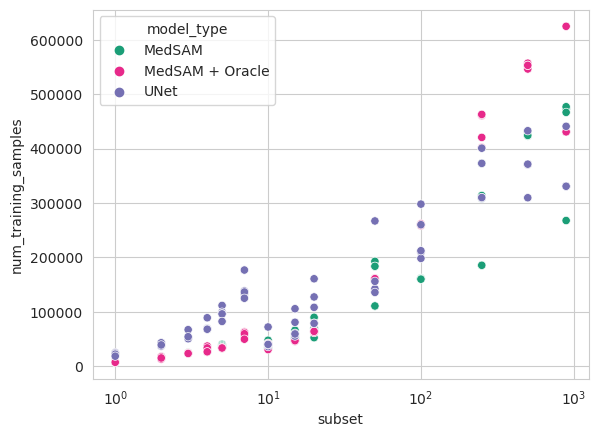

In [32]:
comb_df_label1 = combined_df[combined_df['label'] == 1]

fig, ax = plt.subplots()
sns.scatterplot(data=comb_df_label1, x='subset', y='num_training_samples', hue='model_type', palette=my_colors, ax = ax)
#ax.set_yscale('log')
ax.set_xscale('log')

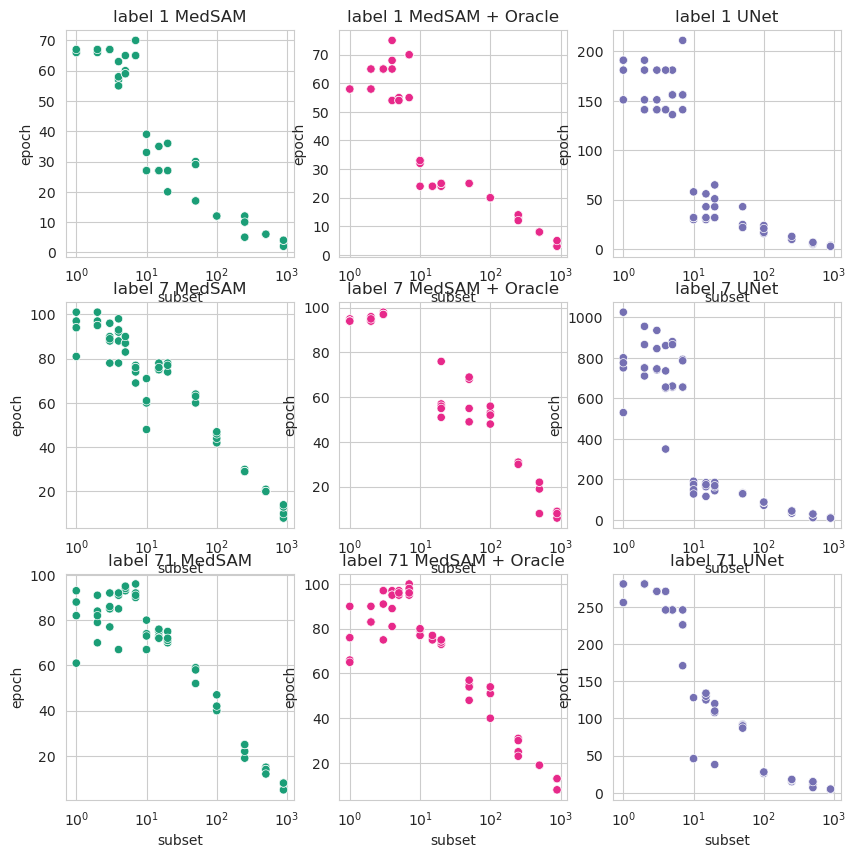

In [41]:
label = 1
models = ['MedSAM', 'MedSAM + Oracle', 'UNet']

fig, ax = plt.subplots(3, 3, figsize=(10,10))
for r, label in enumerate([1,7, 71]):
    for c, model in enumerate(models):
        filter_df = combined_df[(combined_df['label'] == label) & (combined_df['model_type'] == model)]
        sns.scatterplot(data=filter_df, x='subset', y='epoch', hue = 'model_type', ax=ax[r,c], palette=my_colors, legend=None)
        ax[r,c].set_xscale('log')
        ax[r,c].set_title(f'label {label} {model}')

In [ ]:
hist_oracle_subset = get_histories_subset_analysis('subset_medsam_oracle', 'singletask_medsam_no_yolo', min_epoch_cutoff = -1)
hist_constant_subset = get_histories_subset_analysis('subset_medsam_constant', 'singletask_medsam_no_yolo', min_epoch_cutoff = -1)
hist_unet_subset = get_histories_subset_analysis('subset_unet', 'singletask_unet', min_epoch_cutoff = -1)

def process(x, dice_score_name):
    x = x[['_runtime',dice_score_name]].dropna().reset_index(drop=True)
    x['epoch'] = range(0, x.shape[0])
    x = x.rename(columns={dice_score_name: 'val_dice_score'})
    return x

for x in hist_oracle_subset.keys():
    hist_oracle_subset[x] = process(hist_oracle_subset[x], 'val_dice_scores/class_Unknown')
for x in hist_constant_subset.keys():
    hist_constant_subset[x] = process(hist_constant_subset[x], 'val_dice_scores/class_Unknown')
for x in hist_unet_subset.keys():
    hist_unet_subset[x] = process(hist_unet_subset[x], 'val_dice_score')

In [53]:
hist_dict = {'MedSAM + Oracle': hist_oracle_subset, 'MedSAM': hist_constant_subset, 'UNet': hist_unet_subset}

In [54]:
hist_oracle_subset

{(7,
  500,
  4):       _runtime  val_dice_score  epoch
 0   326.720049        0.888349      0
 1   692.434052        0.896036      1
 2  1720.381698        0.890454      2
 3  2486.609169        0.897261      3
 4  3179.612537        0.902166      4
 5  4078.649174        0.902969      5
 6  4924.681212        0.903469      6
 7  6219.300466        0.900841      7,
 (7,
  500,
  3):       _runtime  val_dice_score  epoch
 0   339.381359        0.888182      0
 1   708.278510        0.886012      1
 2  1736.611460        0.884184      2
 3  2503.516869        0.891551      3
 4  3219.018638        0.893747      4
 5  4109.973282        0.899730      5
 6  4941.182934        0.900268      6
 7  6235.799833        0.900261      7,
 (7,
  500,
  2):        _runtime  val_dice_score  epoch
 0    356.676619        0.889450      0
 1    635.671850        0.892179      1
 2    995.107993        0.896780      2
 3   1327.024332        0.902379      3
 4   1689.899774        0.901546      4
 5   

"\nfor label in range(1, 103):\n    # create a dataframe in the long format that contains the dice scores for each model for each epoch\n    # then use seaborn to plot a lineplot for each label, with all labels on different subplots\n\n    df_oracle = pd.DataFrame(hist_oracle[label])\n    df_oracle['model_type'] = 'MedSAM + Oracle'\n\n    df_constant = pd.DataFrame(hist_constant[label])\n    df_constant['model_type'] = 'MedSAM'\n\n    if label in hist_yolo:\n        df_yolo = pd.DataFrame(hist_yolo[label])\n        df_yolo['model_type'] = 'MedSAM + YOLO'\n    else:\n        df_yolo = pd.DataFrame()\n\n    df_unet = pd.DataFrame(hist_unet[label])\n    df_unet['model_type'] = 'UNet'\n\n    combined_df = pd.concat([df_oracle, df_constant, df_yolo, df_unet], axis=0, ignore_index=True)\n    combined_df['label'] = label\n    combined_df = combined_df.sort_values(['model_type', 'epoch']).reset_index(drop=True)\n\n    r = (label-1)//10\n    c = (label-1)%10\n    sns.lineplot(data=combined_df, 

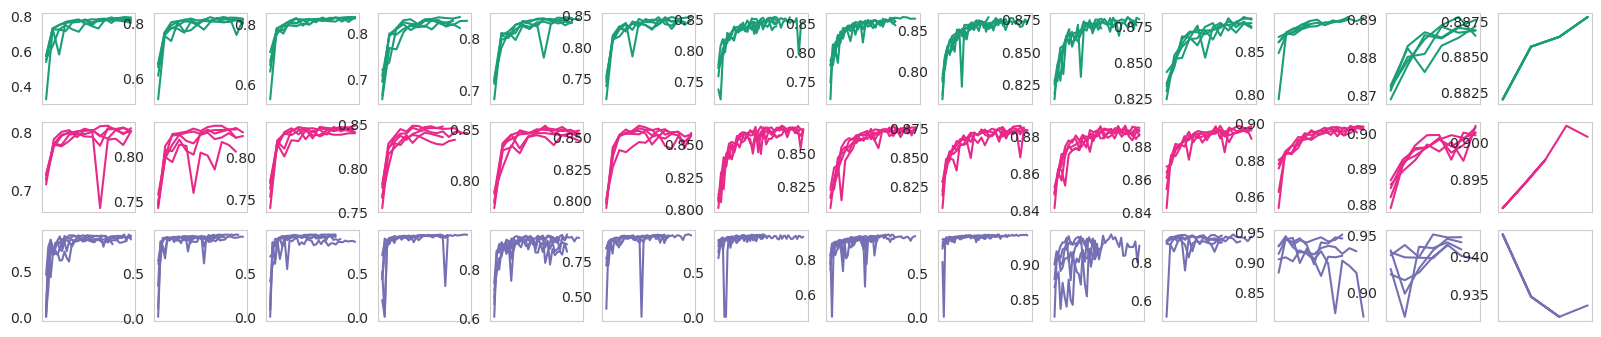

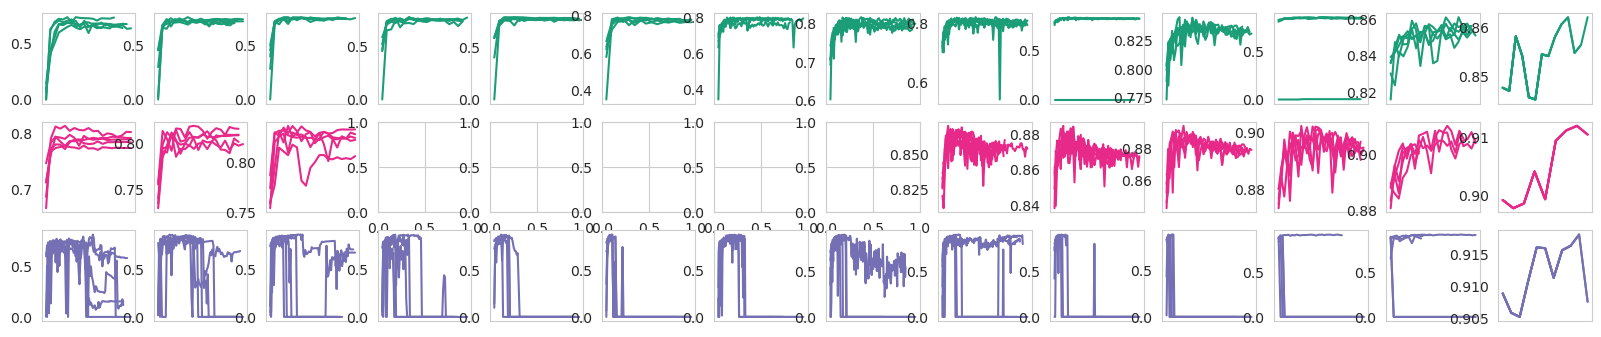

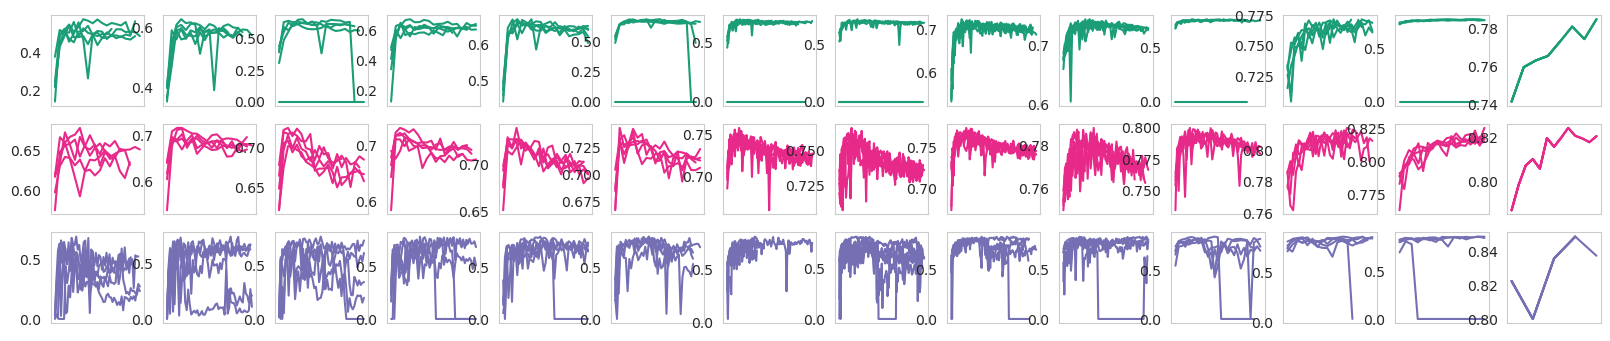

In [68]:

# row = model type
# column = subset size
# each plot contains the 5 repeats

for i, label in enumerate([1, 7, 71]):
    fig, axs = plt.subplots(3, 14, figsize=(20, 4))

    for r, model in enumerate(['MedSAM', 'MedSAM + Oracle', 'UNet']):
        for c, subset in enumerate([1, 2, 3, 4, 5, 7, 10, 15, 20, 50, 100, 250, 500, 891]):
            if (label, subset, 0) not in hist_dict[model]:
                continue
            # assemble the data to be plotted
            concat_list = []
            for repeat in range(5):
                idx_tuple = (label, subset, repeat)
                hists = hist_dict[model][idx_tuple]
                hists['repeat'] = repeat
                hists['model_type'] = model
                concat_list.append(hists)
            concat_df = pd.concat(concat_list, axis=0, ignore_index=True)
            sns.lineplot(data=concat_df, x='epoch', y='val_dice_score', units='repeat', hue='model_type', ax=axs[r,c], legend=None, palette=my_colors,estimator=None)
            axs[r,c].grid(False)
            axs[r,c].set_xticks([])
            #axs[r,c].set_yticks([])
            axs[r,c].set_xlabel('')
            axs[r,c].set_ylabel('')
                
        


'''
for label in range(1, 103):
    # create a dataframe in the long format that contains the dice scores for each model for each epoch
    # then use seaborn to plot a lineplot for each label, with all labels on different subplots

    df_oracle = pd.DataFrame(hist_oracle[label])
    df_oracle['model_type'] = 'MedSAM + Oracle'

    df_constant = pd.DataFrame(hist_constant[label])
    df_constant['model_type'] = 'MedSAM'

    if label in hist_yolo:
        df_yolo = pd.DataFrame(hist_yolo[label])
        df_yolo['model_type'] = 'MedSAM + YOLO'
    else:
        df_yolo = pd.DataFrame()

    df_unet = pd.DataFrame(hist_unet[label])
    df_unet['model_type'] = 'UNet'

    combined_df = pd.concat([df_oracle, df_constant, df_yolo, df_unet], axis=0, ignore_index=True)
    combined_df['label'] = label
    combined_df = combined_df.sort_values(['model_type', 'epoch']).reset_index(drop=True)

    r = (label-1)//10
    c = (label-1)%10
    sns.lineplot(data=combined_df, x='epoch', y='val_dice_score', hue='model_type', ax=axs[r,c], legend=None, palette=my_colors)
    axs[r,c].set_ylabel('')

    
'''
    

In [ ]:
# what is the delta in validation dice score between the last two epochs for each model and each label at each subset size


In [69]:
from segmentation_models_pytorch.encoders import get_preprocessing_fn

preprocess_input = get_preprocessing_fn('resnet18', pretrained='imagenet')

/gpfs/home/kn2347/.conda/envs/medsam/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [82]:
np.array([10, 11, 13]) / 255.0

functools.partial(<function preprocess_input at 0x1554fe6a1cf0>, input_space='RGB', input_range=[0, 1], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [91]:
891 * 256

228096

In [81]:
preprocess_input(np.array([10, 11, 13]))

array([-1.94665639, -1.84313725, -1.57786492])

In [83]:
fi = pd.read_csv('/gpfs/data/luilab/karthik/pediatric_seg_proj/path_df_unet.csv').loc[128,'img_slice_path']

img = Image.open(fi)

# get np array from img
np.array(img).shape

(256, 256, 3)